## Interpolation Test Stimuli Performance V3

Two objectives:
- Training Data
- Model comparison
    - collapsed, and by individual

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from behav import plotting, utils, loading
from starling_rhythm.utils.analysis import stim_parser, plot_subject_acquisition, acquisition_data_preprocessing

from starling_rhythm.utils.paths import PROCESSED_DIR, FIGURE_DIR
import pandas as pd

import seaborn as sns
sns.set_style("ticks")

data_path = '/mnt/cube/RawData/Magpi/'

subjects = (
    ['B1520', 'B1535']
)

/home/AD/j8xing/starling_rhythm_mfdfa/starling_rhythm/utils/analysis.py:1: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
%%time
behav_data = loading.load_data_pandas(subjects, data_path)

CPU times: user 1.17 s, sys: 90 ms, total: 1.26 s
Wall time: 3.49 s


## Clean debug trials and parse stim info

In [3]:
behav_data['B1520'] = behav_data['B1520'][behav_data['B1520'].index > '2023-01-19 00:00:00.000000'] 
## B1520 started trials on the 19th, previous are debug trials

behav_data['B1535'] = behav_data['B1535'][behav_data['B1535'].index > '2023-01-20 00:00:00.000000'] 
## B1535 started trials on the 20th, previous are debug trials

In [4]:
behav_data = stim_parser(behav_data)

Output stim labels for B1520: 113622it [00:11, 9861.83it/s] 
Output stim labels for B1535: 107712it [00:10, 9823.81it/s] 


In [5]:
behav_data['B1520']

,session,index,type_,stimulus,class_,response,correct,rt,reward,punish,data_file,stim_type,pair_indices,inter_nums
time,,,,,,,,,,,,,,
2023-01-19 08:29:21.892792,1,0,normal,/home/bird/opdat/B1520/stimuli/shuffleGap_0_ma...,L,none,NaN,NaN,False,False,/mnt/cube/RawData/Magpi/B1520/B1520_trialdata_...,training,0,max
2023-01-19 08:30:09.815002,1,1,normal,/home/bird/opdat/B1520/stimuli/shuffleGap_0_mi...,R,right,True,2.318338,True,False,/mnt/cube/RawData/Magpi/B1520/B1520_trialdata_...,training,0,min
2023-01-19 08:30:41.696664,1,2,normal,/home/bird/opdat/B1520/stimuli/shuffleGap_0_ma...,L,none,NaN,NaN,False,False,/mnt/cube/RawData/Magpi/B1520/B1520_trialdata_...,training,0,max
2023-01-19 08:31:03.881424,1,3,normal,/home/bird/opdat/B1520/stimuli/shuffleGap_0_ma...,L,none,NaN,NaN,False,False,/mnt/cube/RawData/Magpi/B1520/B1520_trialdata_...,training,0,max
2023-01-19 08:31:53.056560,1,4,normal,/home/bird/opdat/B1520/stimuli/shuffleGap_0_ma...,L,none,NaN,NaN,False,False,/mnt/cube/RawData/Magpi/B1520/B1520_trialdata_...,training,0,max
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-14 16:52:44.360989,25,25,correction,/home/bird/opdat/B1520/stimuli/shuffleGap_1_ma...,L,left,True,0.969583,False,False,/mnt/cube/RawData/Magpi/B1520/B1520_trialdata_...,training,1,max
2023-05-14 16:53:12.699624,25,26,test,/home/bird/opdat/B1520/salv_interpolate/shuffl...,L,left,True,0.016380,False,False,/mnt/cube/RawData/Magpi/B1520/B1520_trialdata_...,INTER,0,32
2023-05-14 16:53:41.097504,25,27,test,/home/bird/opdat/B1520/salv_interpolate/shuffl...,L,right,False,0.921415,False,False,/mnt/cube/RawData/Magpi/B1520/B1520_trialdata_...,INTER,1,16


### For every test trial, only keep if the previous 100 trial accuracy is > 0.8

In [6]:
from starling_rhythm.utils.analysis import test_filter

In [7]:
test_data, training_data = test_filter(behav_data, accuracy_threshold = 0.8, past_baseline_trials = 100)

Iterating through test trials for subject B1520: 4737it [00:41, 113.09it/s]
Iterating through test trials for subject B1535: 4192it [00:47, 87.79it/s]


## Plot acquisition data

Plot accuracy (y) over time (x) for each stimuli

/home/AD/j8xing/starling_rhythm_mfdfa/starling_rhythm/utils/analysis.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data[subj]['day'] = [
/home/AD/j8xing/starling_rhythm_mfdfa/starling_rhythm/utils/analysis.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data[subj]['day'] = [


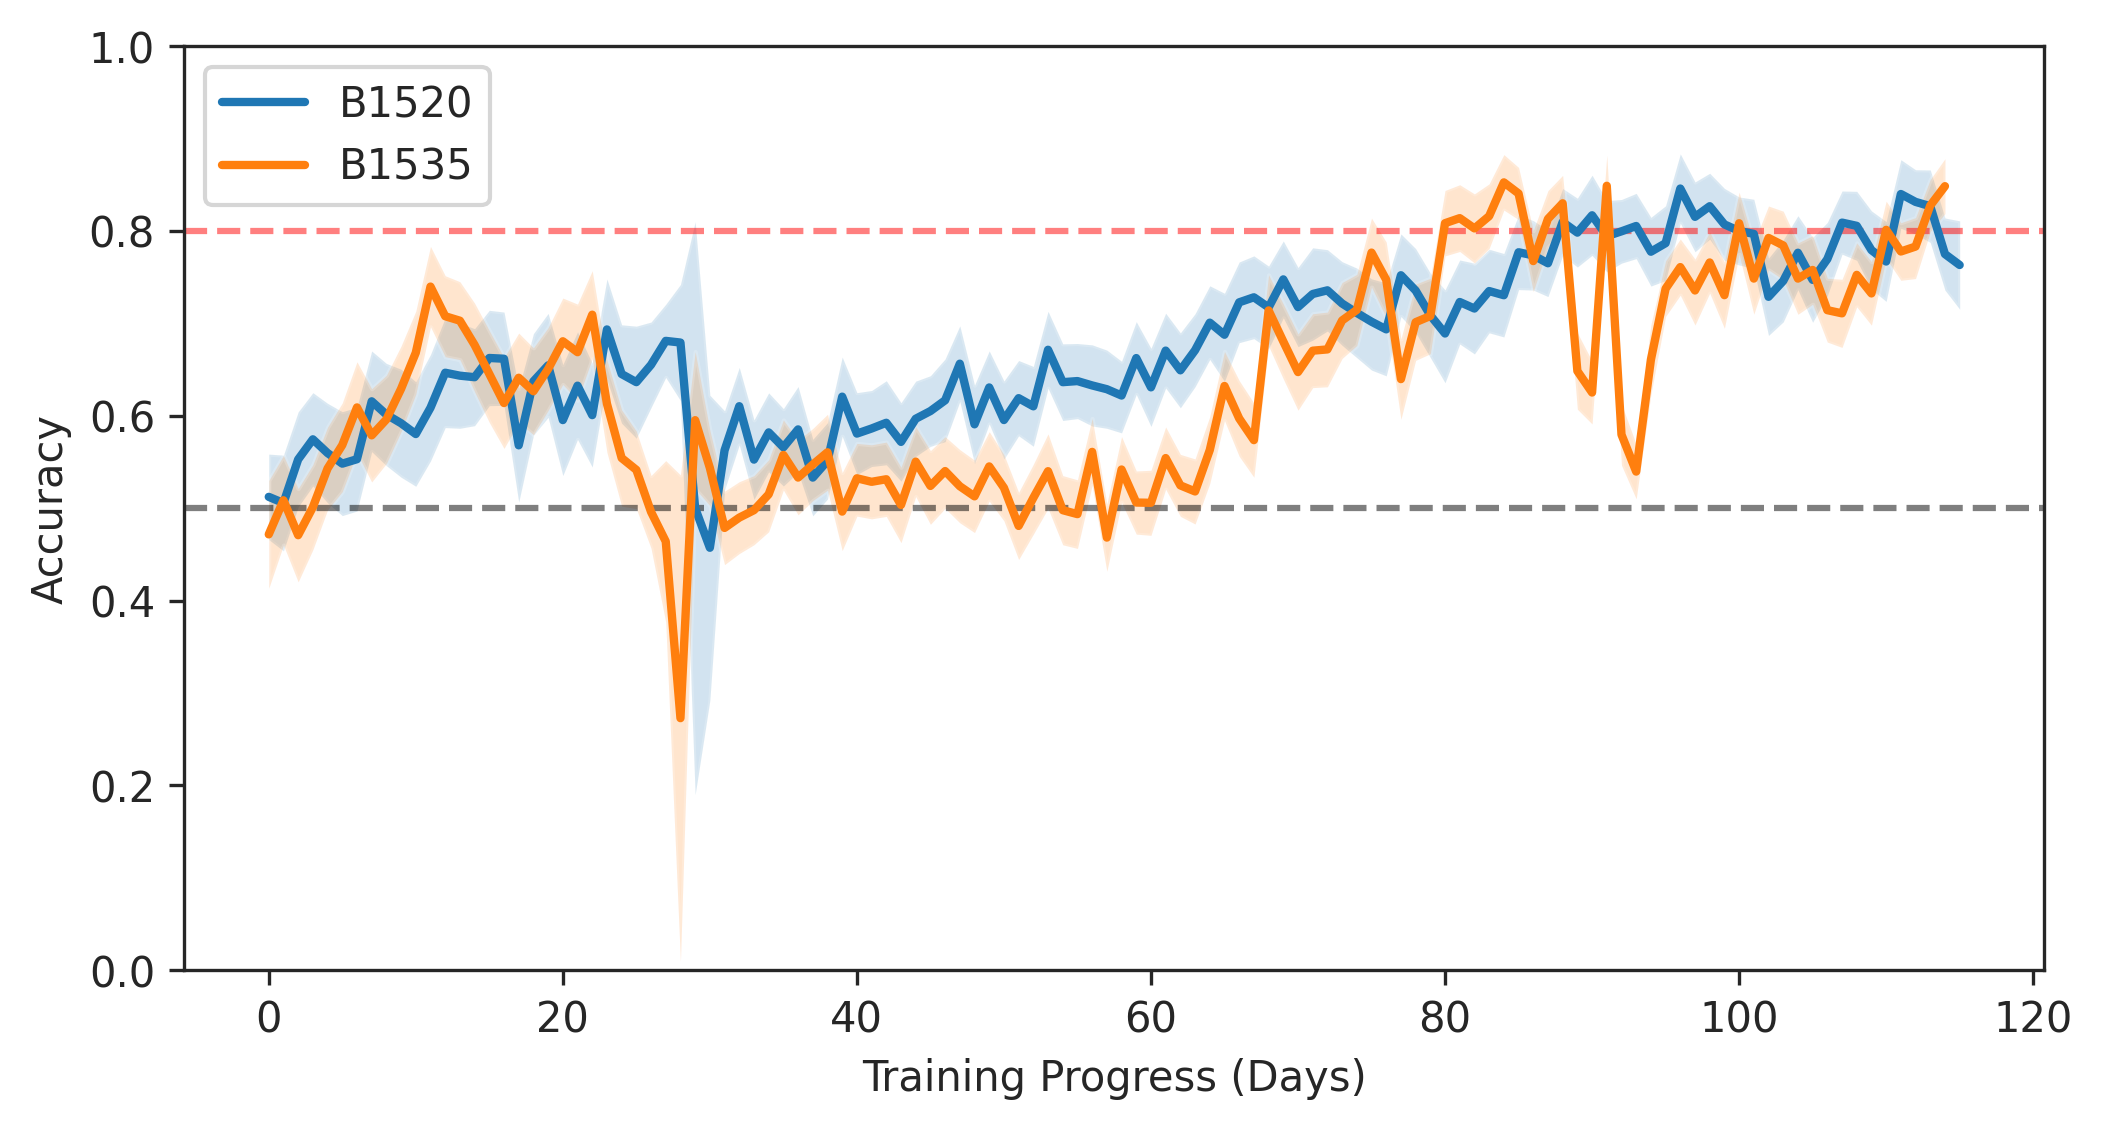

In [8]:
plot_subject_acquisition(behav_data)

plt.savefig(FIGURE_DIR / 'F4_A_acquisition.pdf', dpi = 'figure', format = 'pdf', transparent = True)

## Plot pre-test data by bird and stimuli

In [9]:
from statsmodels.stats.proportion import proportion_confint

In [10]:
test_data

{'B1520':                              time session index type_  \
 86150  2023-04-19 12:30:29.868374       1   102  test   
 86221  2023-04-19 13:35:31.927146       1    29  test   
 86243  2023-04-19 13:50:33.334587       1    51  test   
 86244  2023-04-19 13:50:49.443718       1    52  test   
 86247  2023-04-19 13:51:52.317272       1    55  test   
 ...                           ...     ...   ...   ...   
 112935 2023-05-14 07:42:39.080378      22   129  test   
 112947 2023-05-14 07:49:33.187021      22   141  test   
 112958 2023-05-14 08:01:15.623374      22   152  test   
 112968 2023-05-14 08:06:47.571406      22   162  test   
 113009 2023-05-14 09:05:31.865580      22   203  test   
 
                                                  stimulus class_ response  \
 86150   /home/bird/opdat/B1520/salv_interpolate/shuffl...      R     left   
 86221   /home/bird/opdat/B1520/salv_interpolate/shuffl...      R     left   
 86243   /home/bird/opdat/B1520/salv_interpolate/shuffl... 

In [11]:
trainB1520 = behav_data['B1520'].reset_index()
trainB1535 = behav_data['B1535'].reset_index()

trainB1520['bID'] = 'B1520'
trainB1535['bID'] = 'B1535'

trainB1520 = trainB1520[trainB1520.type_ == 'normal']
trainB1535 = trainB1535[trainB1535.type_ == 'normal']

trainB1520 = trainB1520[trainB1520.time < test_data['B1520'].time.values[0]]
trainB1535 = trainB1535[trainB1535.time < test_data['B1535'].time.values[0]]

trainB1520 = trainB1520.iloc[-1000:]
trainB1535 = trainB1535.iloc[-1000:]

pretest = pd.concat([trainB1520, trainB1535])

In [12]:
groupby_list = ['bID', 'pair_indices', 'inter_nums']

In [13]:
pretest_data = pd.DataFrame(
    pretest.groupby(
        groupby_list
    )['correct'].agg(['mean', 'count'])
)

In [14]:
test_data['B1520']

,time,session,index,type_,stimulus,class_,response,correct,rt,reward,punish,data_file,stim_type,pair_indices,inter_nums
86150,2023-04-19 12:30:29.868374,1,102,test,/home/bird/opdat/B1520/salv_interpolate/shuffl...,R,left,False,0.047982,False,False,/mnt/cube/RawData/Magpi/B1520/B1520_trialdata_...,INTER,0,96
86221,2023-04-19 13:35:31.927146,1,29,test,/home/bird/opdat/B1520/salv_interpolate/shuffl...,R,left,False,0.204056,False,False,/mnt/cube/RawData/Magpi/B1520/B1520_trialdata_...,INTER,0,72
86243,2023-04-19 13:50:33.334587,1,51,test,/home/bird/opdat/B1520/salv_interpolate/shuffl...,R,right,True,0.375426,False,False,/mnt/cube/RawData/Magpi/B1520/B1520_trialdata_...,INTER,0,100
86244,2023-04-19 13:50:49.443718,1,52,test,/home/bird/opdat/B1520/salv_interpolate/shuffl...,L,left,True,0.360404,False,False,/mnt/cube/RawData/Magpi/B1520/B1520_trialdata_...,INTER,0,32
86247,2023-04-19 13:51:52.317272,1,55,test,/home/bird/opdat/B1520/salv_interpolate/shuffl...,L,left,True,0.547329,False,False,/mnt/cube/RawData/Magpi/B1520/B1520_trialdata_...,INTER,0,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112935,2023-05-14 07:42:39.080378,22,129,test,/home/bird/opdat/B1520/salv_interpolate/shuffl...,L,left,True,0.110038,False,False,/mnt/cube/RawData/Magpi/B1520/B1520_trialdata_...,INTER,0,40
112947,2023-05-14 07:49:33.187021,22,141,test,/home/bird/opdat/B1520/salv_interpolate/shuffl...,L,left,True,0.297344,False,False,/mnt/cube/RawData/Magpi/B1520/B1520_trialdata_...,INTER,0,16
112958,2023-05-14 08:01:15.623374,22,152,test,/home/bird/opdat/B1520/salv_interpolate/shuffl...,R,right,True,0.375204,False,False,/mnt/cube/RawData/Magpi/B1520/B1520_trialdata_...,INTER,0,64
112968,2023-05-14 08:06:47.571406,22,162,test,/home/bird/opdat/B1520/salv_interpolate/shuffl...,L,left,True,0.125672,False,False,/mnt/cube/RawData/Magpi/B1520/B1520_trialdata_...,INTER,0,4


In [15]:
pretest_data

mean  count
bID   pair_indices inter_nums                 
B1520 0            max         0.916667    240
                   min         0.737069    232
      1            max         0.823529    238
                   min         0.740157    254
B1535 0            max         0.669421    242
                   min         0.842105    247
      1            max         0.585062    241
                   min         0.741036    251

In [16]:
## calculate binomial CI
binomial_lower = []
binomial_upper = []

for i, row in pretest_data.iterrows():
    
    try:
        lower, upper = proportion_confint(int(row['mean'] * row['count']), row['count'], alpha = 0.05)
    except:
        lower = np.nan
        upper = np.nan
    
    binomial_lower.append(lower)
    binomial_upper.append(upper)
    
pretest_data['lower'] = binomial_lower
pretest_data['upper'] = binomial_upper

In [17]:
pretest_data = pretest_data.reset_index()

In [18]:
pretest_data['dummy_names'] = pretest_data['pair_indices'] + pretest_data['inter_nums']

In [19]:
pretest_data

,bID,pair_indices,inter_nums,mean,count,lower,upper,dummy_names
0,B1520,0,max,0.916667,240,0.881700,0.951634,0max
1,B1520,0,min,0.737069,232,0.680422,0.793716,0min
2,B1520,1,max,0.823529,238,0.775097,0.871962,1max
3,B1520,1,min,0.740157,254,0.686225,0.794090,1min
4,B1535,0,max,0.669421,242,0.610152,0.728690,0max
5,B1535,0,min,0.842105,247,0.796631,0.887580,0min
6,B1535,1,max,0.585062,241,0.522856,0.647268,1max
7,B1535,1,min,0.741036,251,0.686842,0.795230,1min


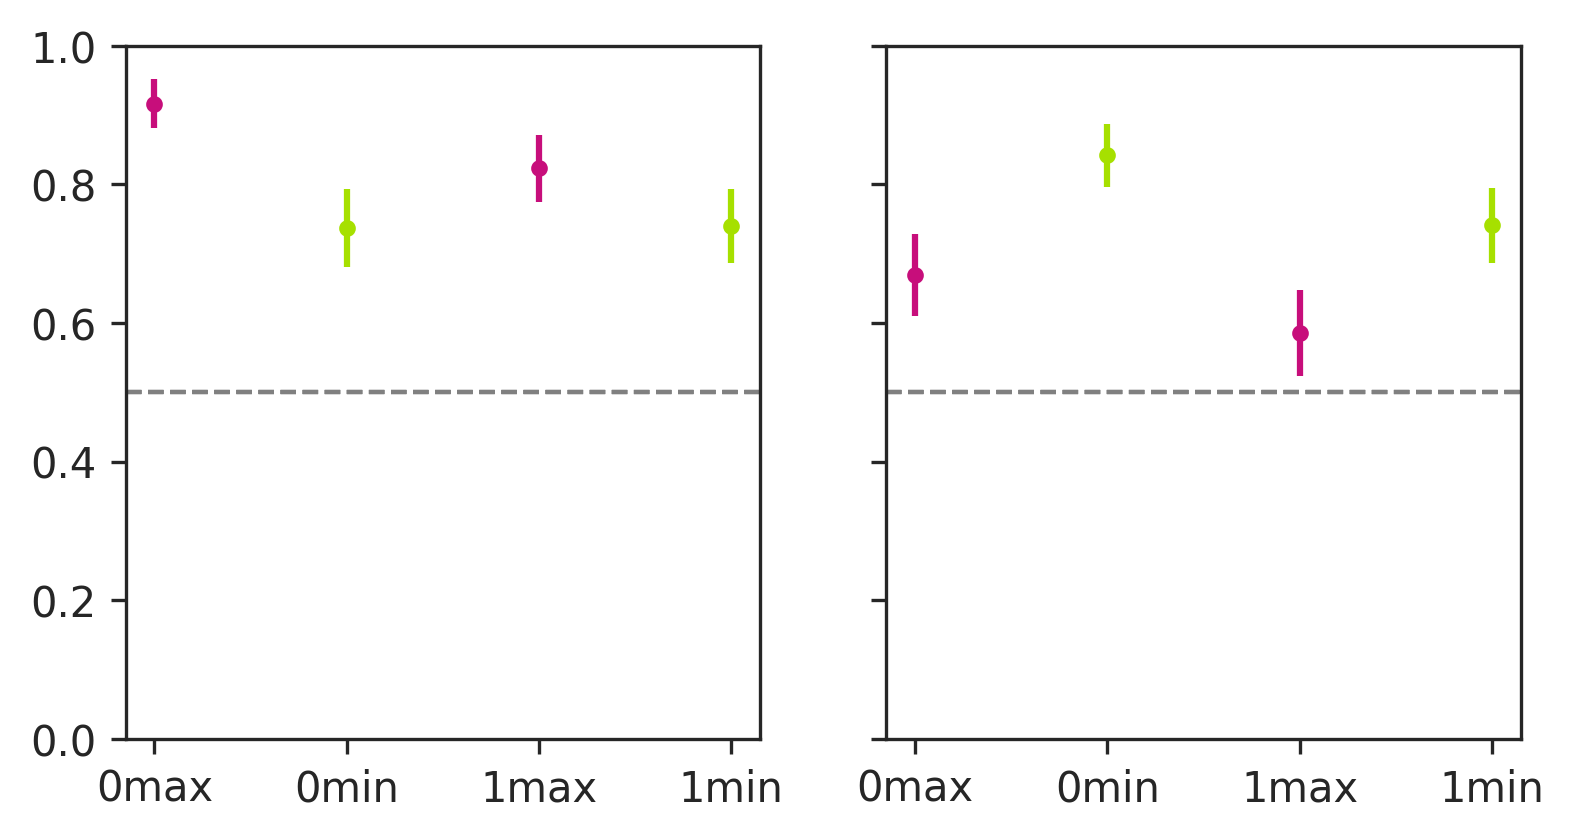

In [20]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (6, 3), dpi = 300, sharey = True)

colors = ["#C70E7B","#A6E000","#C70E7B","#A6E000", "#C70E7B","#A6E000","#C70E7B","#A6E000"]
sns.set_palette(sns.color_palette(colors))

for i, bID in zip(np.arange(0, len(np.unique(pretest_data['bID']))), np.unique(pretest_data['bID'])):
    select = pretest_data[pretest_data.bID == bID]
    for j, row in select.iterrows():
        axes[i].errorbar(x = row.dummy_names, y = row['mean'], yerr = [[row['mean'] - row.lower], [row.upper - row['mean']]], fmt = 'none', color = colors[j])
        axes[i].plot(row.dummy_names, row['mean'], marker = '.', color = colors[j])
        axes[i].axhline(y = 0.5, linewidth = 1, ls = '--', color = 'gray')

axes[0].set_ylim([0, 1])

plt.savefig(FIGURE_DIR / 'F4_B_pretest.pdf', dpi = 'figure', format = 'pdf', transparent = True)

## Main test 

### Obtain psychometric function

In [21]:
test_data = pd.concat(test_data)

In [22]:
PMFX = pd.DataFrame(test_data.groupby(
    'inter_nums'
)['response'].agg('value_counts', normalize = True))
PMFX = PMFX.rename(columns = {'response': 'prop'})

In [24]:
PMFX = PMFX.reset_index()

In [25]:
PMFX

,inter_nums,response,prop
0,0,left,0.821429
1,0,right,0.151786
2,0,none,0.026786
3,4,left,0.822034
4,4,right,0.135593
...,...,...,...
93,124,right,0.768595
94,124,left,0.173554
95,124,none,0.057851
96,127,right,0.722222


## Only conduct test on left

In [27]:
PMFX_L = PMFX[PMFX.response == 'left']

In [28]:
PMFX_L['rank'] = PMFX_L['inter_nums'].rank(ascending = False)
PMFX_L = PMFX_L.sort_values(by = 'rank')
PMFX_L['inter_degree'] = np.linspace(0, 1, 33)

/tmp/ipykernel_10752/1359255609.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PMFX_L['rank'] = PMFX_L['inter_nums'].rank(ascending = False)


## Graph psychometric function

<AxesSubplot:xlabel='inter_degree', ylabel='prop'>

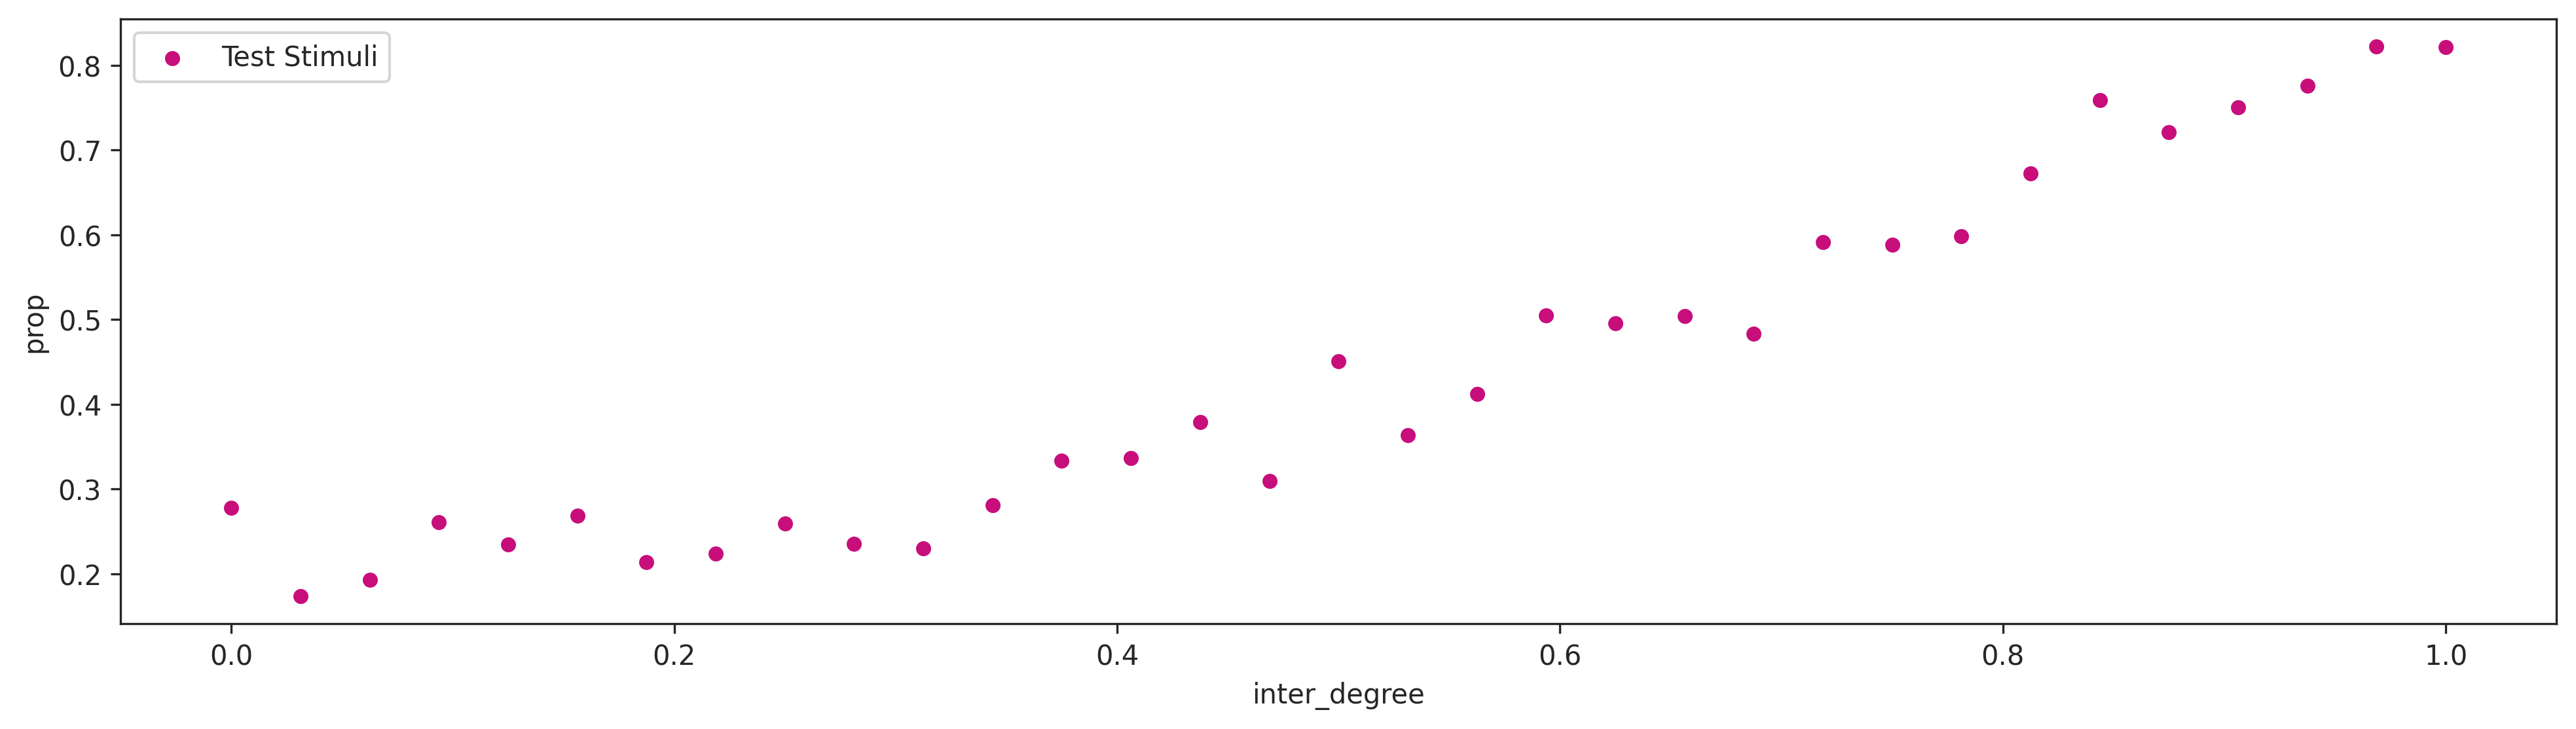

In [30]:
plt.figure(figsize = (16, 4), dpi = 300)
sns.scatterplot(
    data = PMFX_L,
    x = 'inter_degree',
    y = 'prop',
    label = 'Test Stimuli'
)

## Graph hypotheses on top

### get training baseline

In [34]:
bID = "s_b1555_22"
SAVE_PATH = PROCESSED_DIR / bID / 'salvage_inter_tmf.pickle'
stims = pd.read_pickle(SAVE_PATH)

In [35]:
grouped_training_data = pd.concat(training_data)

In [36]:
baseline_accuracies = pd.DataFrame(
    grouped_training_data.groupby(
        ['inter_nums']
    )['response'].agg('value_counts', normalize = True)
)

baseline_accuracies = baseline_accuracies.rename(columns = {'response': 'prop'})

In [38]:
baseline_accuracies

prop
inter_nums response          
max        left      0.848645
           right     0.113415
           none      0.037940
min        right     0.731727
           left      0.222268
           none      0.046005

### Hypothesis 1: Linear

In [56]:
### From left baseline to right baseline, there is a linear relationship in the linear interpolation space
hypo1_linear = (
    np.linspace(1, 0, 33), 
    np.linspace(left_baseline, right_baseline, 33)
)

### Hypothesis 2: MF

In [233]:
mf_function = list(stims.groupby('interpolation_num')['mean_tMF'].agg('mean')[::4].values)
mf_function.append(stims.groupby('interpolation_num')['mean_tMF'].agg('mean').iloc[-1])
len(mf_function)

33

In [82]:
def normalize(x, normalize_anchors, newRange=(0, 1)): #x is an array. Default range is between zero and one
    xmin, xmax = normalize_anchors #get max and min from input array
    norm = (x - xmin)/(xmax - xmin) # scale between zero and one
    
    if newRange == (0, 1):
        return(norm) # wanted range is the same as norm
    elif newRange != (0, 1):
        return norm * (newRange[1] - newRange[0]) + newRange[0] #scale to a different range.    
    #add other conditions here. For example, an error message

In [83]:
left_baseline = baseline_accuracies.loc[('max', 'left')].values[0]
right_baseline = baseline_accuracies.loc[('max', 'right')].values[0]

In [84]:
hypo2_linear = (
    np.linspace(1, 0, 33),
    normalize(
        x = mf_function, 
        normalize_anchors = (mf_function[0], mf_function[-1]), 
        newRange = (left_baseline, right_baseline)
    )
)

In [85]:
hypo1_linear

(array([1.     , 0.96875, 0.9375 , 0.90625, 0.875  , 0.84375, 0.8125 ,
        0.78125, 0.75   , 0.71875, 0.6875 , 0.65625, 0.625  , 0.59375,
        0.5625 , 0.53125, 0.5    , 0.46875, 0.4375 , 0.40625, 0.375  ,
        0.34375, 0.3125 , 0.28125, 0.25   , 0.21875, 0.1875 , 0.15625,
        0.125  , 0.09375, 0.0625 , 0.03125, 0.     ]),
 array([0.84864499, 0.82566904, 0.80269309, 0.77971714, 0.75674119,
        0.73376524, 0.7107893 , 0.68781335, 0.6648374 , 0.64186145,
        0.6188855 , 0.59590955, 0.5729336 , 0.54995766, 0.52698171,
        0.50400576, 0.48102981, 0.45805386, 0.43507791, 0.41210196,
        0.38912602, 0.36615007, 0.34317412, 0.32019817, 0.29722222,
        0.27424627, 0.25127033, 0.22829438, 0.20531843, 0.18234248,
        0.15936653, 0.13639058, 0.11341463]))

In [86]:
hypo2_linear

(array([1.     , 0.96875, 0.9375 , 0.90625, 0.875  , 0.84375, 0.8125 ,
        0.78125, 0.75   , 0.71875, 0.6875 , 0.65625, 0.625  , 0.59375,
        0.5625 , 0.53125, 0.5    , 0.46875, 0.4375 , 0.40625, 0.375  ,
        0.34375, 0.3125 , 0.28125, 0.25   , 0.21875, 0.1875 , 0.15625,
        0.125  , 0.09375, 0.0625 , 0.03125, 0.     ]),
 array([0.84864499, 0.81486201, 0.8083892 , 0.7716522 , 0.73572671,
        0.697566  , 0.67517085, 0.68749086, 0.76652369, 0.78947545,
        0.76770346, 0.80856481, 0.85343799, 0.79872194, 0.76991533,
        0.715773  , 0.68912389, 0.62016109, 0.63096029, 0.61163754,
        0.48747865, 0.49634284, 0.46545357, 0.4255512 , 0.36952791,
        0.32986837, 0.30113586, 0.29261817, 0.21292473, 0.19149259,
        0.15901864, 0.17570919, 0.11341463]))

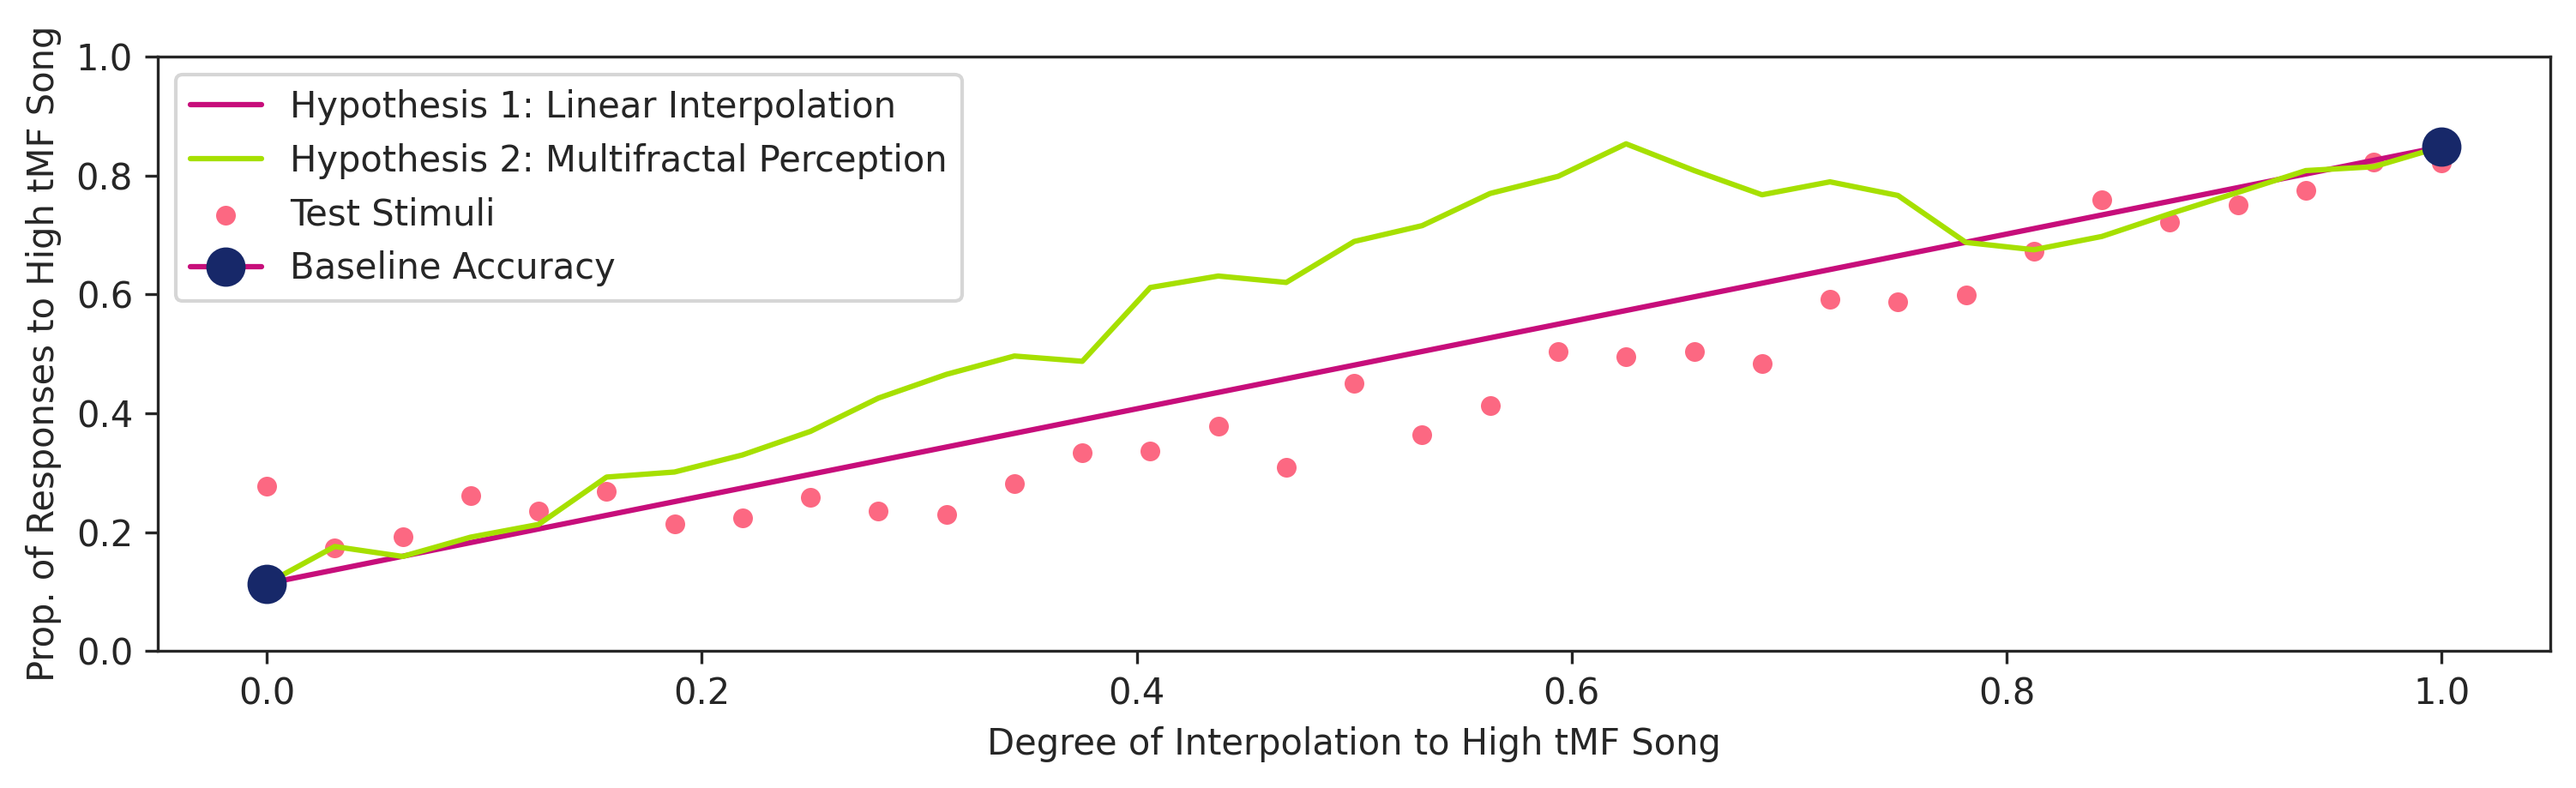

In [399]:
plt.figure(figsize = (12, 3), dpi = 300)

plt.plot(
    hypo1_linear[0],
    hypo1_linear[1],
    label = 'Hypothesis 1: Linear Interpolation'
)

plt.plot(
    hypo2_linear[0],
    hypo2_linear[1],
    label = 'Hypothesis 2: Multifractal Perception'
)

sns.scatterplot(
    data = PMFX_L,
    x = 'inter_degree',
    y = 'prop',
    label = 'Test Stimuli',
    color = '#FC6882'
)

plt.plot(1, left_baseline, marker = 'o', markerfacecolor = '#172869', markeredgecolor = '#172869', markersize = 10, label = 'Baseline Accuracy')
plt.plot(0, right_baseline, marker = 'o', markerfacecolor = '#172869', markeredgecolor = '#172869', markersize = 10)

plt.ylim(0, 1)
plt.ylabel('Prop. of Responses to High tMF Song')
plt.xlabel('Degree of Interpolation to High tMF Song')

plt.legend()

plt.savefig(FIGURE_DIR / 'F5_A_Combined.pdf', dpi = 'figure', format = 'pdf', transparent = True)

### Add linear and multifractal prediction to PMFX

In [357]:
PMFX_L['linear_pred'] = np.flip(hypo1_linear[1])
PMFX_L['mf_pred'] = np.flip(hypo2_linear[1])

## calculate R^2

In [358]:
from sklearn.metrics import r2_score

In [359]:
r2_score(PMFX_L['prop'][1:-1], PMFX_L['linear_pred'][1:-1])

0.8599674254789389

In [360]:
r2_score(PMFX_L['prop'][1:-1], PMFX_L['mf_pred'][1:-1])

-0.015284277009976144

## CHI square

In [361]:
import scipy.stats

In [362]:
CHI_count = pd.DataFrame(test_data.groupby(
    ['inter_nums']
)['response'].agg(
    total = 'count'
)).reset_index()

In [363]:
CHI_count.head()

,inter_nums,total
0,0,112
1,4,118
2,8,98
3,12,120
4,16,122


In [364]:
CHI_count = CHI_count.sort_values(by = 'inter_nums', ascending = False)

In [365]:
linear_exp = (PMFX_L['linear_pred'].values * CHI_count['total']).values[1:-1]
linear_exp = linear_exp * (sum((PMFX_L['prop'].values[1:-1] * CHI_count['total'][1:-1]).astype(int))/ sum(linear_exp))
linear_exp

array([14.84429082, 15.62475862, 18.86146387, 21.23809066, 24.43609893,
       26.44336763, 28.61464905, 28.87318753, 34.27326723, 34.88049749,
       39.85053795, 39.9010954 , 40.77435216, 37.17751362, 46.55696825,
       57.54576018, 54.85428623, 54.03685824, 54.90879717, 57.20275868,
       62.71275912, 65.68739137, 69.28069538, 60.9965557 , 81.66467338,
       72.24520394, 73.92049368, 83.0418288 , 84.16044573, 70.75633004,
       87.63502314])

In [366]:
mf_exp = (PMFX_L['mf_pred'].values * CHI_count['total']).values[1:-1]
mf_exp = mf_exp * (sum((PMFX_L['prop'].values[1:-1] * CHI_count['total'][1:-1]).astype(int))/ sum(mf_exp))
mf_exp

array([15.92546637, 12.98335232, 16.49537303, 18.34155996, 26.08318163,
       26.39129242, 28.66229652, 29.89395105, 37.93246741, 39.39736047,
       44.98621444, 41.62677564, 50.39635571, 44.89913215, 52.4922606 ,
       68.65327531, 64.87434665, 65.74460694, 66.40960732, 70.95896419,
       70.86193584, 67.85593237, 70.96303654, 58.56498938, 67.97561959,
       57.14844881, 58.52152597, 67.23395721, 69.3609705 , 59.34155141,
       72.02419225])

In [367]:
scipy.stats.chisquare(
    f_obs = (PMFX_L['prop'].values * CHI_count['total']).astype(int)[1:-1],
    f_exp = linear_exp
)

Power_divergenceResult(statistic=31.557325068438438, pvalue=0.3883933854278115)

In [368]:
scipy.stats.chisquare(
    f_obs = (PMFX_L['prop'].values * CHI_count['total']).astype(int)[1:-1],
    f_exp = mf_exp
)

Power_divergenceResult(statistic=113.14074335286504, pvalue=1.4059357109641342e-11)

## Breakdown by stimuli

### find training baseline for each pair

In [369]:
baseline_accuracies_0 = pd.DataFrame(
    grouped_training_data.groupby(
        ['inter_nums', 'pair_indices']
    )['response'].agg('value_counts', normalize = True)
)

baseline_accuracies_0 = baseline_accuracies_0.rename(columns = {'response': 'prop'})

In [370]:
baseline_accuracies_0

prop
inter_nums pair_indices response          
max        0            left      0.857266
                        right     0.110775
                        none      0.031959
           1            left      0.834121
                        right     0.117861
                        none      0.048017
min        0            right     0.757224
                        left      0.207340
                        none      0.035436
           1            right     0.685342
                        left      0.249424
                        none      0.065234

In [371]:
left_baseline_0 = baseline_accuracies_0.loc['max', '0', 'left'].values[0]
right_baseline_0 = baseline_accuracies_0.loc['max', '0', 'right'].values[0]
left_baseline_1 = baseline_accuracies_0.loc['max', '1', 'left'].values[0]
right_baseline_1 = baseline_accuracies_0.loc['max', '1', 'right'].values[0]

## Find Hypotheses

### Hypothesis 1

In [372]:
### From left baseline to right baseline, there is a linear relationship in the linear interpolation space
hypo1_linear_0 = (
    np.linspace(1, 0, 33), 
    np.linspace(left_baseline_0, right_baseline_0, 33)
)
### From left baseline to right baseline, there is a linear relationship in the linear interpolation space
hypo1_linear_1 = (
    np.linspace(1, 0, 33), 
    np.linspace(left_baseline_1, right_baseline_1, 33)
)

### Hypothesis 2

In [373]:
mf_fx = pd.DataFrame(stims.groupby(['pair_index','interpolation_num'])['mean_tMF'].agg('mean'))

In [374]:
mf_fx

mean_tMF
pair_index interpolation_num           
0          0                  90.494647
           1                  83.142759
           2                  95.858954
           3                  93.250860
           4                  86.461456
...                                 ...
1          123                11.347009
           124                13.625525
           125                11.443044
           126                 7.166905
           127                 8.396061

[256 rows x 1 columns]

In [375]:
mf_function_0 = list(mf_fx.loc[0].mean_tMF.values[::4])
mf_function_0.append(mf_fx.loc[0].mean_tMF.values[-1])

In [376]:
mf_function_1 = list(mf_fx.loc[1].mean_tMF.values[::4])
mf_function_1.append(mf_fx.loc[1].mean_tMF.values[-1])

In [377]:
hypo2_linear_0 = (
    np.linspace(1, 0, 33),
    normalize(
        x = mf_function_0, 
        normalize_anchors = (mf_function_0[0], mf_function_0[-1]), 
        newRange = (left_baseline_0, right_baseline_0)
    )
)
hypo2_linear_1 = (
    np.linspace(1, 0, 33),
    normalize(
        x = mf_function_1, 
        normalize_anchors = (mf_function_1[0], mf_function_1[-1]), 
        newRange = (left_baseline_1, right_baseline_1)
    )
)

### pair 0

In [378]:
test_data_0 = test_data[test_data.pair_indices == '0']

In [379]:
PMFX_0 = pd.DataFrame(test_data_0.groupby(
    'inter_nums'
)['response'].agg('value_counts', normalize = True))
PMFX_0 = PMFX_0.rename(columns = {'response': 'prop'})
PMFX_0 = PMFX_0.reset_index()
PMFX_0_L = PMFX_0[PMFX_0.response == 'left']
PMFX_0_L['rank'] = PMFX_0_L['inter_nums'].rank(ascending = False)
PMFX_0_L = PMFX_0_L.sort_values(by = 'rank')
PMFX_0_L['inter_degree'] = np.linspace(0, 1, 33)

/tmp/ipykernel_10752/2085838134.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PMFX_0_L['rank'] = PMFX_0_L['inter_nums'].rank(ascending = False)


In [380]:
mf_function = list(stims.groupby('interpolation_num')['mean_tMF'].agg('mean')[::4].values)
mf_function.append(stims.groupby('interpolation_num')['mean_tMF'].agg('mean').iloc[-1])
len(mf_function)

33

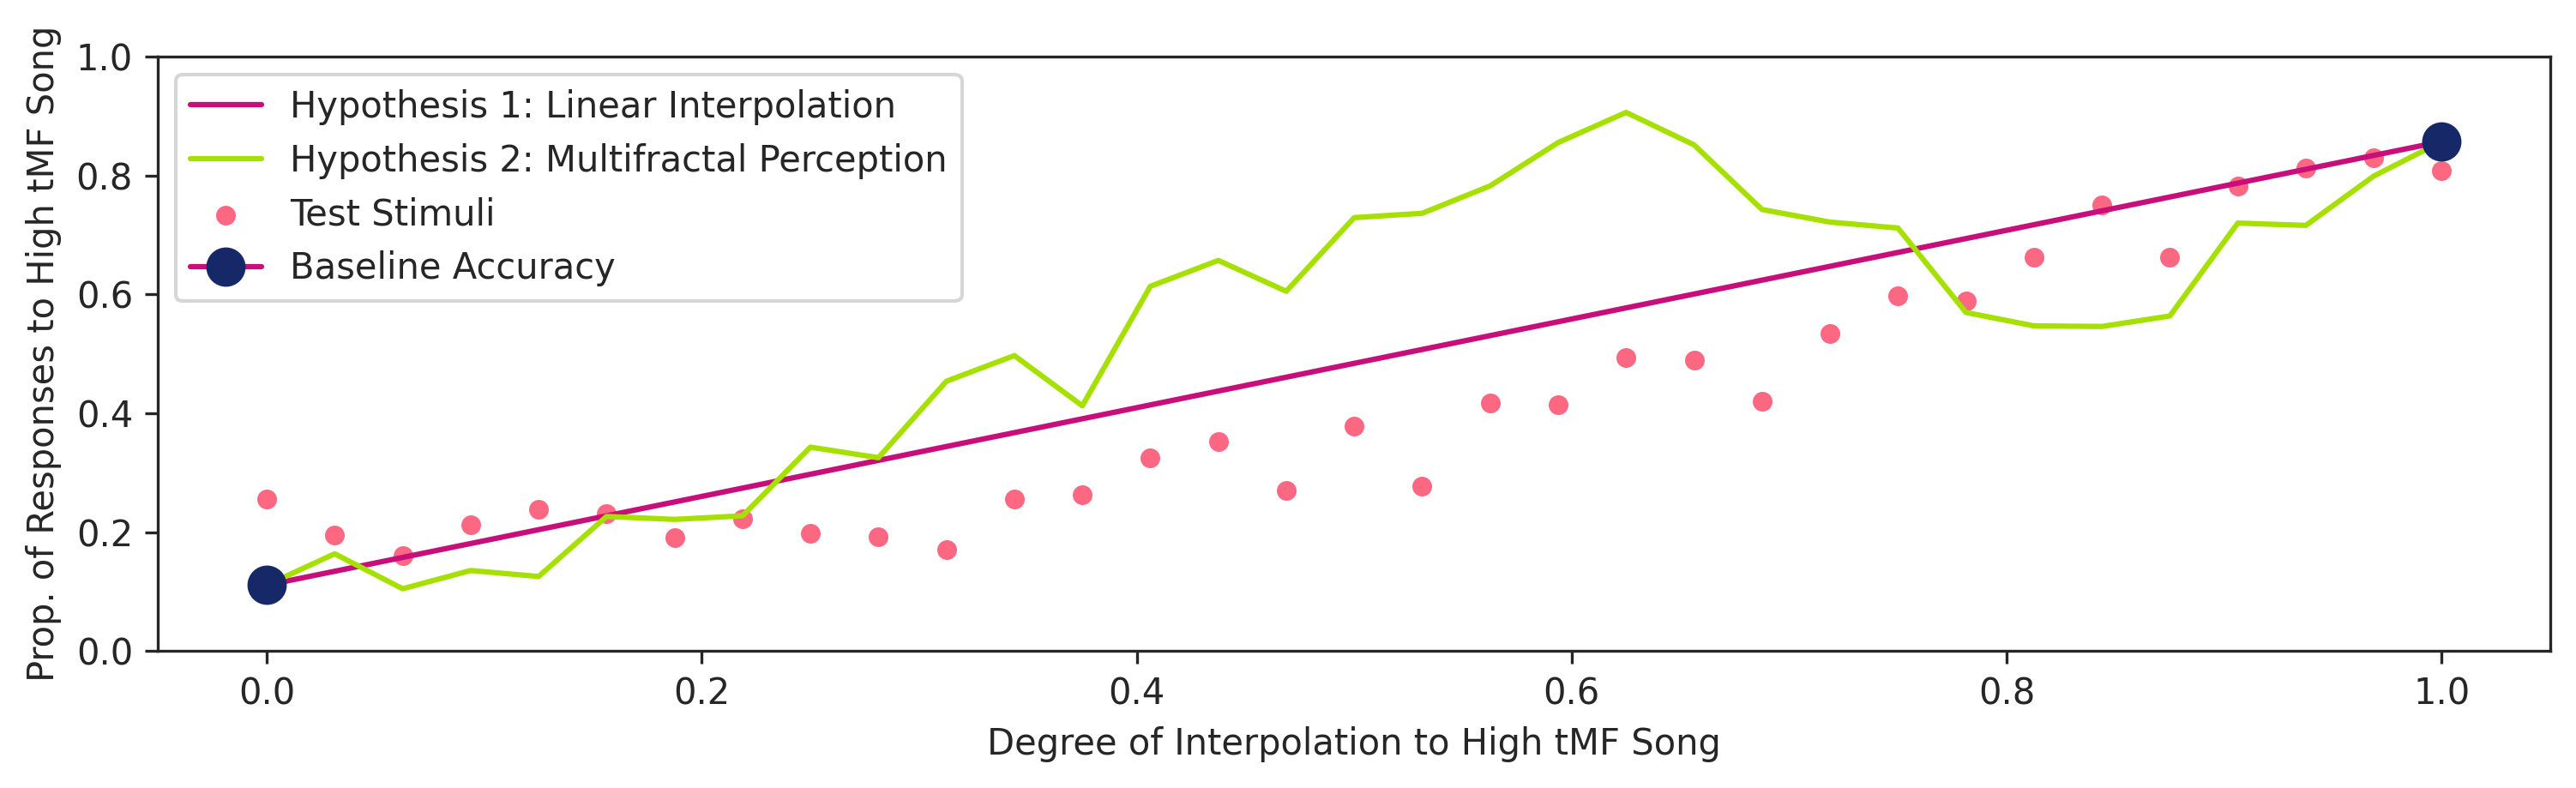

In [400]:
plt.figure(figsize = (12, 3), dpi = 300)

plt.plot(
    hypo1_linear_0[0],
    hypo1_linear_0[1],
    label = 'Hypothesis 1: Linear Interpolation'
)

plt.plot(
    hypo2_linear_0[0],
    hypo2_linear_0[1],
    label = 'Hypothesis 2: Multifractal Perception'
)

sns.scatterplot(
    data = PMFX_0_L,
    x = 'inter_degree',
    y = 'prop',
    label = 'Test Stimuli',
    color = '#FC6882'
)

plt.plot(1, left_baseline_0, marker = 'o', markerfacecolor = '#172869', markeredgecolor = '#172869', markersize = 10, label = 'Baseline Accuracy')
plt.plot(0, right_baseline_0, marker = 'o', markerfacecolor = '#172869', markeredgecolor = '#172869', markersize = 10)

plt.ylim(0, 1)

plt.legend()

plt.ylim(0, 1)
plt.ylabel('Prop. of Responses to High tMF Song')
plt.xlabel('Degree of Interpolation to High tMF Song')

plt.savefig(FIGURE_DIR / 'F5_B_Index0.pdf', dpi = 'figure', format = 'pdf', transparent = True)

In [382]:
PMFX_0_L['linear_pred'] = np.flip(hypo1_linear_0[1])
PMFX_0_L['mf_pred'] = np.flip(hypo2_linear_0[1])

#### R2

In [383]:
r2_score(PMFX_0_L['prop'][1:-1], PMFX_0_L['linear_pred'][1:-1])

0.7423261702156049

In [384]:
r2_score(PMFX_0_L['prop'][1:-1], PMFX_0_L['mf_pred'][1:-1])

-0.26296850255003434

#### CHI

In [385]:
CHI_count_0 = pd.DataFrame(test_data_0.groupby(
    ['inter_nums']
)['response'].agg(
    total = 'count'
)).reset_index()

CHI_count_0 = CHI_count_0.sort_values(by = 'inter_nums', ascending = False)

linear_exp_0 = (PMFX_0_L['linear_pred'].values * CHI_count_0['total']).values[1:-1]
linear_exp_0 = linear_exp_0 * (sum((PMFX_0_L['prop'].values[1:-1] * CHI_count_0['total'][1:-1]).astype(int))/ sum(linear_exp_0))

mf_exp_0 = (PMFX_0_L['mf_pred'].values * CHI_count_0['total']).values[1:-1]
mf_exp_0 = mf_exp_0 * (sum((PMFX_0_L['prop'].values[1:-1] * CHI_count_0['total'][1:-1]).astype(int))/ sum(mf_exp_0))

In [386]:
scipy.stats.chisquare(
    f_obs = (PMFX_0_L['prop'].values * CHI_count_0['total']).astype(int)[1:-1],
    f_exp = linear_exp_0
)

Power_divergenceResult(statistic=39.12112660264237, pvalue=0.12303820173574556)

In [387]:
scipy.stats.chisquare(
    f_obs = (PMFX_0_L['prop'].values * CHI_count_0['total']).astype(int)[1:-1],
    f_exp = mf_exp_0
)

Power_divergenceResult(statistic=187.64742535563667, pvalue=9.865107963651544e-25)

### pair 1

In [388]:
test_data_1 = test_data[test_data.pair_indices == '1']

In [389]:
PMFX_1 = pd.DataFrame(test_data_1.groupby(
    'inter_nums'
)['response'].agg('value_counts', normalize = True))
PMFX_1 = PMFX_1.rename(columns = {'response': 'prop'})
PMFX_1 = PMFX_1.reset_index()
PMFX_1_L = PMFX_1[PMFX_1.response == 'left']
PMFX_1_L['rank'] = PMFX_1_L['inter_nums'].rank(ascending = False)
PMFX_1_L = PMFX_1_L.sort_values(by = 'rank')
PMFX_1_L['inter_degree'] = np.linspace(0, 1, 33)

/tmp/ipykernel_10752/282608787.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PMFX_1_L['rank'] = PMFX_1_L['inter_nums'].rank(ascending = False)


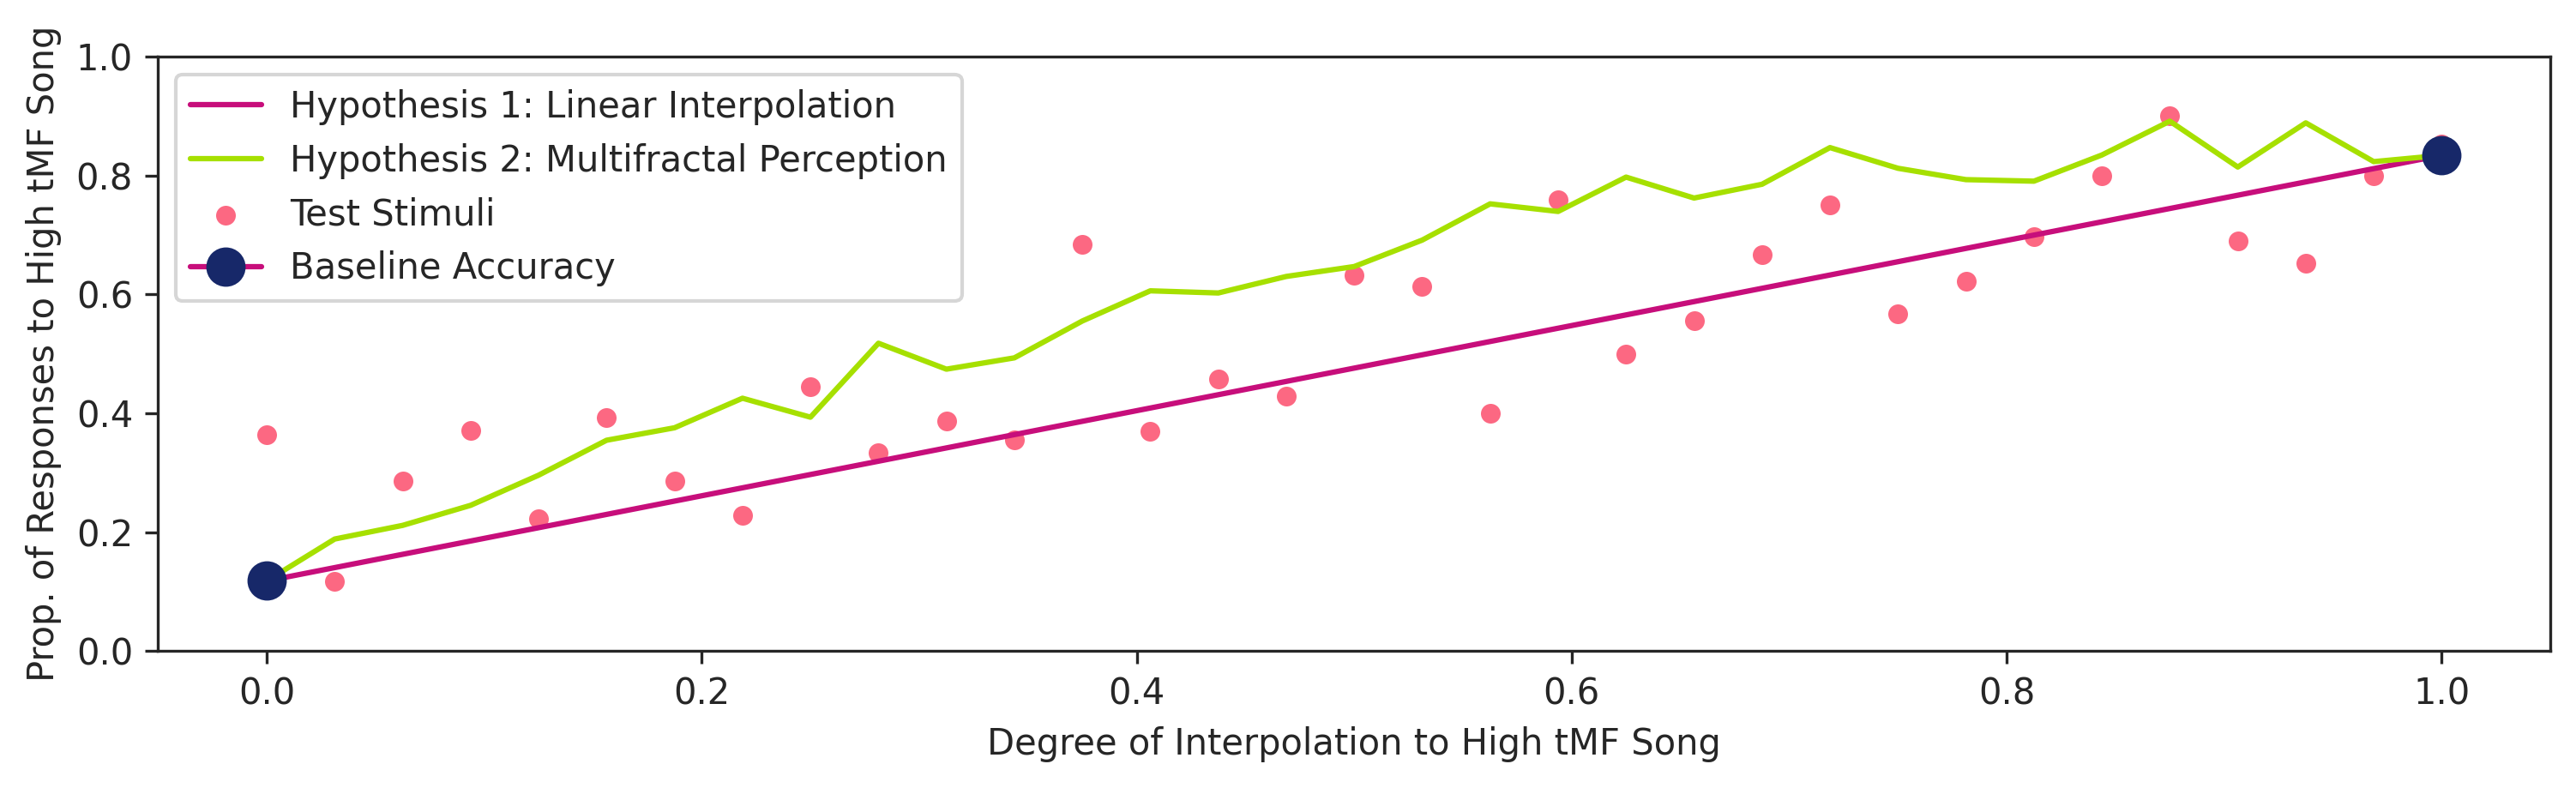

In [401]:
plt.figure(figsize = (12, 3), dpi = 300)

plt.plot(
    hypo1_linear_1[0],
    hypo1_linear_1[1],
    label = 'Hypothesis 1: Linear Interpolation'
)

plt.plot(
    hypo2_linear_1[0],
    hypo2_linear_1[1],
    label = 'Hypothesis 2: Multifractal Perception'
)

sns.scatterplot(
    data = PMFX_1_L,
    x = 'inter_degree',
    y = 'prop',
    label = 'Test Stimuli',
    color = '#FC6882'
)

plt.plot(1, left_baseline_1, marker = 'o', markerfacecolor = '#172869', markeredgecolor = '#172869', markersize = 10, label = 'Baseline Accuracy')
plt.plot(0, right_baseline_1, marker = 'o', markerfacecolor = '#172869', markeredgecolor = '#172869', markersize = 10)

plt.ylim(0, 1)

plt.legend()

plt.ylim(0, 1)
plt.ylabel('Prop. of Responses to High tMF Song')
plt.xlabel('Degree of Interpolation to High tMF Song')

plt.savefig(FIGURE_DIR / 'F5_C_Index1.pdf', dpi = 'figure', format = 'pdf', transparent = True)

In [391]:
PMFX_1_L['linear_pred'] = np.flip(hypo1_linear_1[1])
PMFX_1_L['mf_pred'] = np.flip(hypo2_linear_1[1])

In [392]:
r2_score(PMFX_1_L['prop'][1:-1], PMFX_1_L['linear_pred'][1:-1])

0.6784066347740829

In [393]:
r2_score(PMFX_1_L['prop'][1:-1], PMFX_1_L['mf_pred'][1:-1])

0.382695323107227

#### CHI

In [394]:
CHI_count_1 = pd.DataFrame(test_data_1.groupby(
    ['inter_nums']
)['response'].agg(
    total = 'count'
)).reset_index()

CHI_count_1 = CHI_count_1.sort_values(by = 'inter_nums', ascending = False)

linear_exp_1 = (PMFX_1_L['linear_pred'].values * CHI_count_1['total']).values[1:-1]
linear_exp_1 = linear_exp_1 * (sum((PMFX_1_L['prop'].values[1:-1] * CHI_count_1['total'][1:-1]).astype(int))/ sum(linear_exp_1))

mf_exp_1 = (PMFX_1_L['mf_pred'].values * CHI_count_1['total']).values[1:-1]
mf_exp_1 = mf_exp_1 * (sum((PMFX_1_L['prop'].values[1:-1] * CHI_count_1['total'][1:-1]).astype(int))/ sum(mf_exp_1))

In [395]:
scipy.stats.chisquare(
    f_obs = (PMFX_1_L['prop'].values * CHI_count_1['total']).astype(int)[1:-1],
    f_exp = linear_exp_1
)

Power_divergenceResult(statistic=25.198608633859255, pvalue=0.7153235379829265)

In [396]:
scipy.stats.chisquare(
    f_obs = (PMFX_1_L['prop'].values * CHI_count_1['total']).astype(int)[1:-1],
    f_exp = mf_exp_1
)

Power_divergenceResult(statistic=24.032844155291883, pvalue=0.7705364875824507)